# Analyze Search Usage on English Wikipedia

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

[TASK](https://phabricator.wikimedia.org/T328600)

## Purpose

We would like to measure the search usage for the Vector 2022 skin post deployment analysis on enwiki. Hypothesis: 5% increase in search usage.


## Methodology

Data comes from events logged in [SearchSatisfaction](https://schema.wikimedia.org/repositories/secondary/jsonschema/analytics/legacy/searchsatisfaction/current.yaml). The dataset include `event.skin` field to determine which skin is being used. SearchSatisfaction is sampled at 100%.

The analysis was limited to searches on English Wikipedia desktop and excludes flagged bot traffic and search sessions with more than 50 searches in a session as these are likely from automated traffic. 

Metrics Reviewed:
* Search sessions initiated with the following breakdowns:
  * Overall
  * By Desktop Skin Type (SearchSatisfactions includes an `event.skin` field to determine which skin is being used)
  * By Logged-in status


## Search Sessions Initiated

A search session begins when a user starts typing in the search widget. This is indicated by event.action = 'searchResultPage' AND event.source = 'autocomplete' in SearchSatisfaction. 

In [77]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse);
     # Tables:
    library(gt);
    library(gtsummary);
})

In [78]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

In [79]:
# collect all search sessions initated from SearchSatisfaction 
query <- 
"
SELECT
    MIN(TO_DATE(dt)) as session_start_date,
    event.searchSessionID as search_session,
    event.isAnon AS is_anonymous,
    event.skinVersion AS vector_version,
    event.skin AS skin,
    wiki AS wiki,
    min(event.usereditbucket) AS edit_count,
    SUM(1) as num_searches
FROM event.searchSatisfaction 
    WHERE YEAR = 2023
    AND MONTH >= 01
    -- remove flagged bots
    AND useragent.is_bot = false 
    AND event.subTest is NULL
-- Looking only at autcomplete searches done using search widget 
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND wiki = 'enwiki'
GROUP BY 
    event.searchSessionID,
    event.isAnon,
    event.extraParams,
    event.skinVersion,
    event.inputLocation,
    event.skin,
    wiki
"

In [80]:
enwiki_search_usage <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [81]:
#format and clean data

enwiki_search_usage$session_start_date <- as.Date(enwiki_search_usage$session_start_date, format = "%Y-%m-%d")

enwiki_search_usage <- enwiki_search_usage %>%
    filter(num_searches < 50) %>% # remove sessions with over 50 searches as these are an indicator of auto/bot traffic
    mutate(
        edit_count = factor(
            edit_count, 
            levels = c("0 edits", "1-4 edits", "5-99 edits", 
                       "100-999 edits", "1000+ edits")
        ),
        is_anonymous = factor(
            is_anonymous, 
            levels = c("true", "false"), 
            labels = c("logged-out", "logged-in")
            
        )
    )

## Overall 

### Daily Trends

In [109]:
# sessions initated overall by group
enwiki_search_initiated_daily <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    group_by(session_start_date ) %>%
    summarise(
             num_sessions = n_distinct(search_session)) 

enwiki_search_initiated_daily

session_start_date,num_sessions
<date>,<int>
2023-01-03,1122596
2023-01-04,1135654
2023-01-05,1139900
2023-01-06,1099953
2023-01-07,899523
2023-01-08,941632
2023-01-09,1183441
2023-01-10,1189839
2023-01-11,1193675


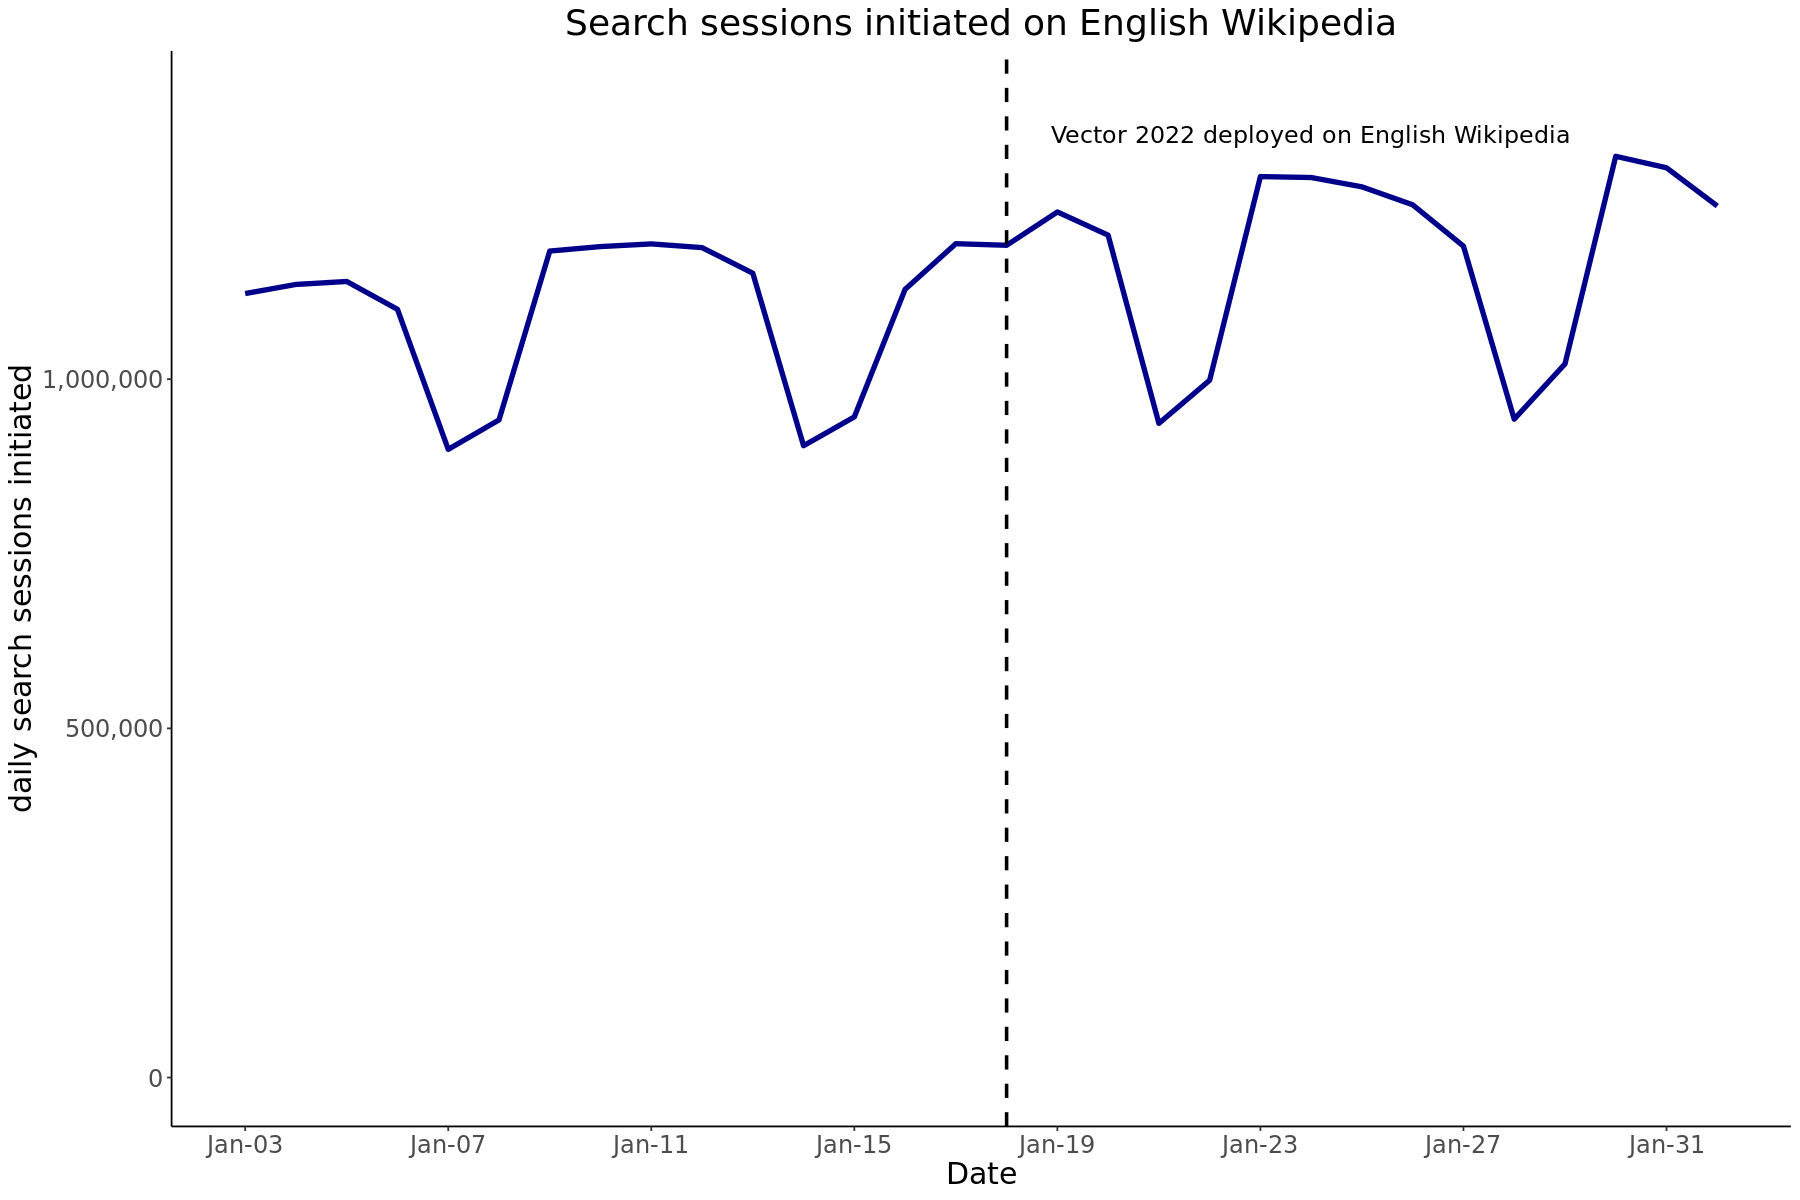

In [146]:
# Chart search sessions initiated over time.

textaes <- data.frame(y = 1350000,
                      x = as.Date('2023-01-24'),
                      lab = "Vector 2022 deployed on English Wikipedia")

p <- enwiki_search_initiated_daily  %>%
    ggplot(aes(x= session_start_date, y = num_sessions)) +    
    geom_line(size =1.5, color = 'darkblue') +
    geom_vline(xintercept = as.Date('2023-01-18'), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    scale_y_continuous(labels = scales::comma, limits = c(0, 1400000)) +
    scale_x_date("Date", date_breaks = "4 days", date_labels = "%b-%d") +
    scale_color_manual(values= "steelblue2") +
  labs(title = "Search sessions initiated on English Wikipedia",
      y = "daily search sessions initiated",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/enwiki_search_initiated_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

There has been a sustained gradual increase in search sessions initiated since deployment as shown in the chart above. We observed an immediate 3.8% increase in search sessions initiated on 19 Jan 2023 (one day after deployment) compared to search sessions initiated on 17 Jan 2023 (one day prior to deployment). 

Note: The occasional dips align with weekends where we typically see lower desktop pageviews.

### Two Week Pre and Post Deployment

We also compared total search sessions initiated two weeks prior (03 Jan 2023 through 17 Jan 2023) and two weeks post-deployment (18 Jan 2023 through 01 Feb 2023).

In [91]:
# sessions initated overall by group
enwiki_search_initiated_overall <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    mutate(pre_post = ifelse( session_start_date < '2023-01-18', 'pre-deployment', 'post-deployment'),
          pre_post = factor(
            pre_post,
            levels = c("pre-deployment", "post-deployment" ))) %>%
    group_by(pre_post) %>%
    summarise(
             num_sessions = n_distinct(search_session)) 

enwiki_search_initiated_overall 

pre_post,num_sessions
<fct>,<int>
pre-deployment,16419007
post-deployment,17699581


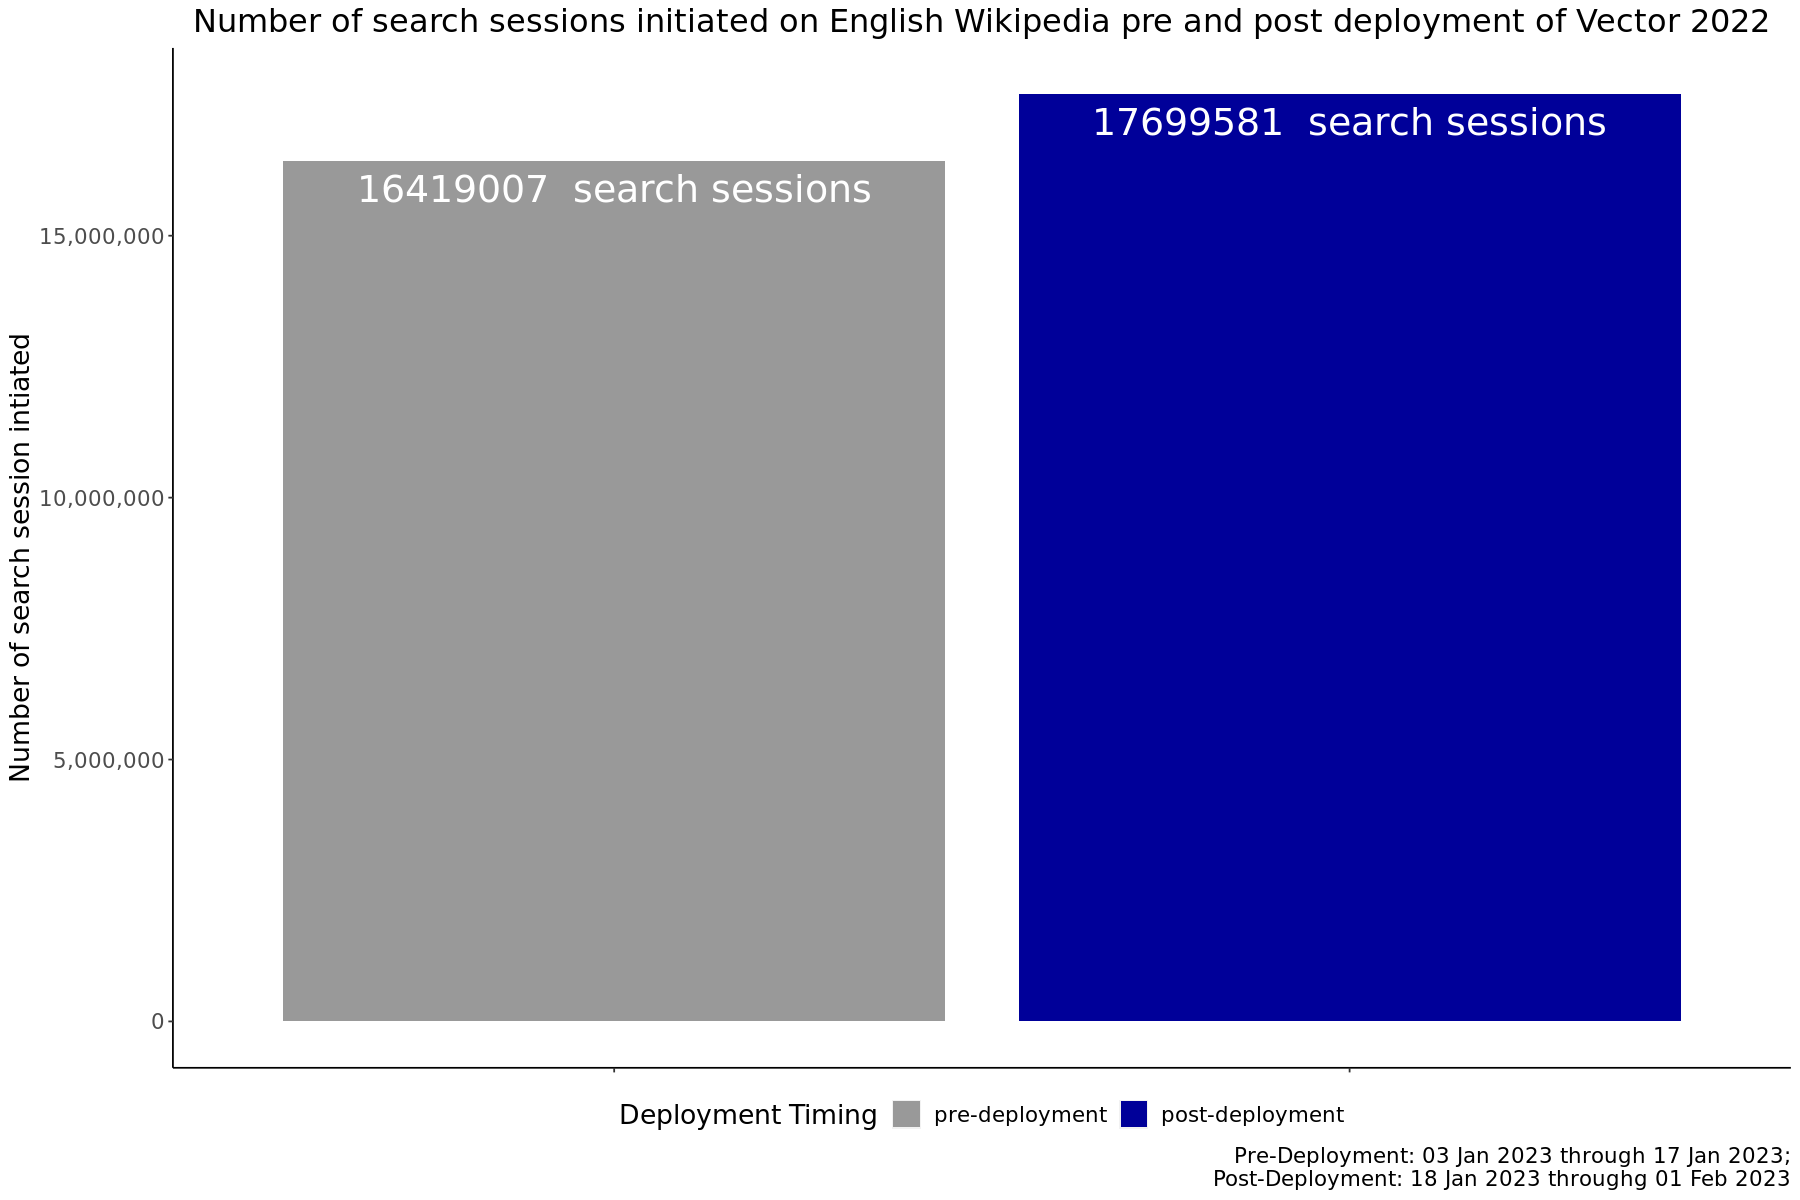

In [150]:
# Plot search sessions initiated by pre and post deployment

p <- enwiki_search_initiated_overall%>%
        ggplot(aes(x = pre_post, y= num_sessions, fill = pre_post)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions,' search sessions')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Deployment Timing",
              y = "Number of search session intiated",
             title = "Number of search sessions initiated on English Wikipedia pre and post deployment of Vector 2022",
             caption = "Pre-Deployment: 03 Jan 2023 through 17 Jan 2023;
                        Post-Deployment: 18 Jan 2023 throughg 01 Feb 2023") +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment Timing")  +
        scale_y_continuous(labels = scales::comma) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/enwiki_search_initiated_overall.png", p, width = 16, height = 8, units = "in", dpi = 300) 

There was a 7.8% increase in the total search sessions initiated on English Wikipedia two weeks post deployment compared to two weeks pre deployment.

## By Skin Version
I took a quick look at search sessions intiated by desktop skin version to confirm that the majority of search sessions iniitated after deployment are on Vector-2022.

### Daily

In [110]:
# sessions initated overall by group
enwiki_search_initiated_byskin_daily <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    group_by(session_start_date, skin ) %>%
    summarise(
             num_sessions = n_distinct(search_session)) 

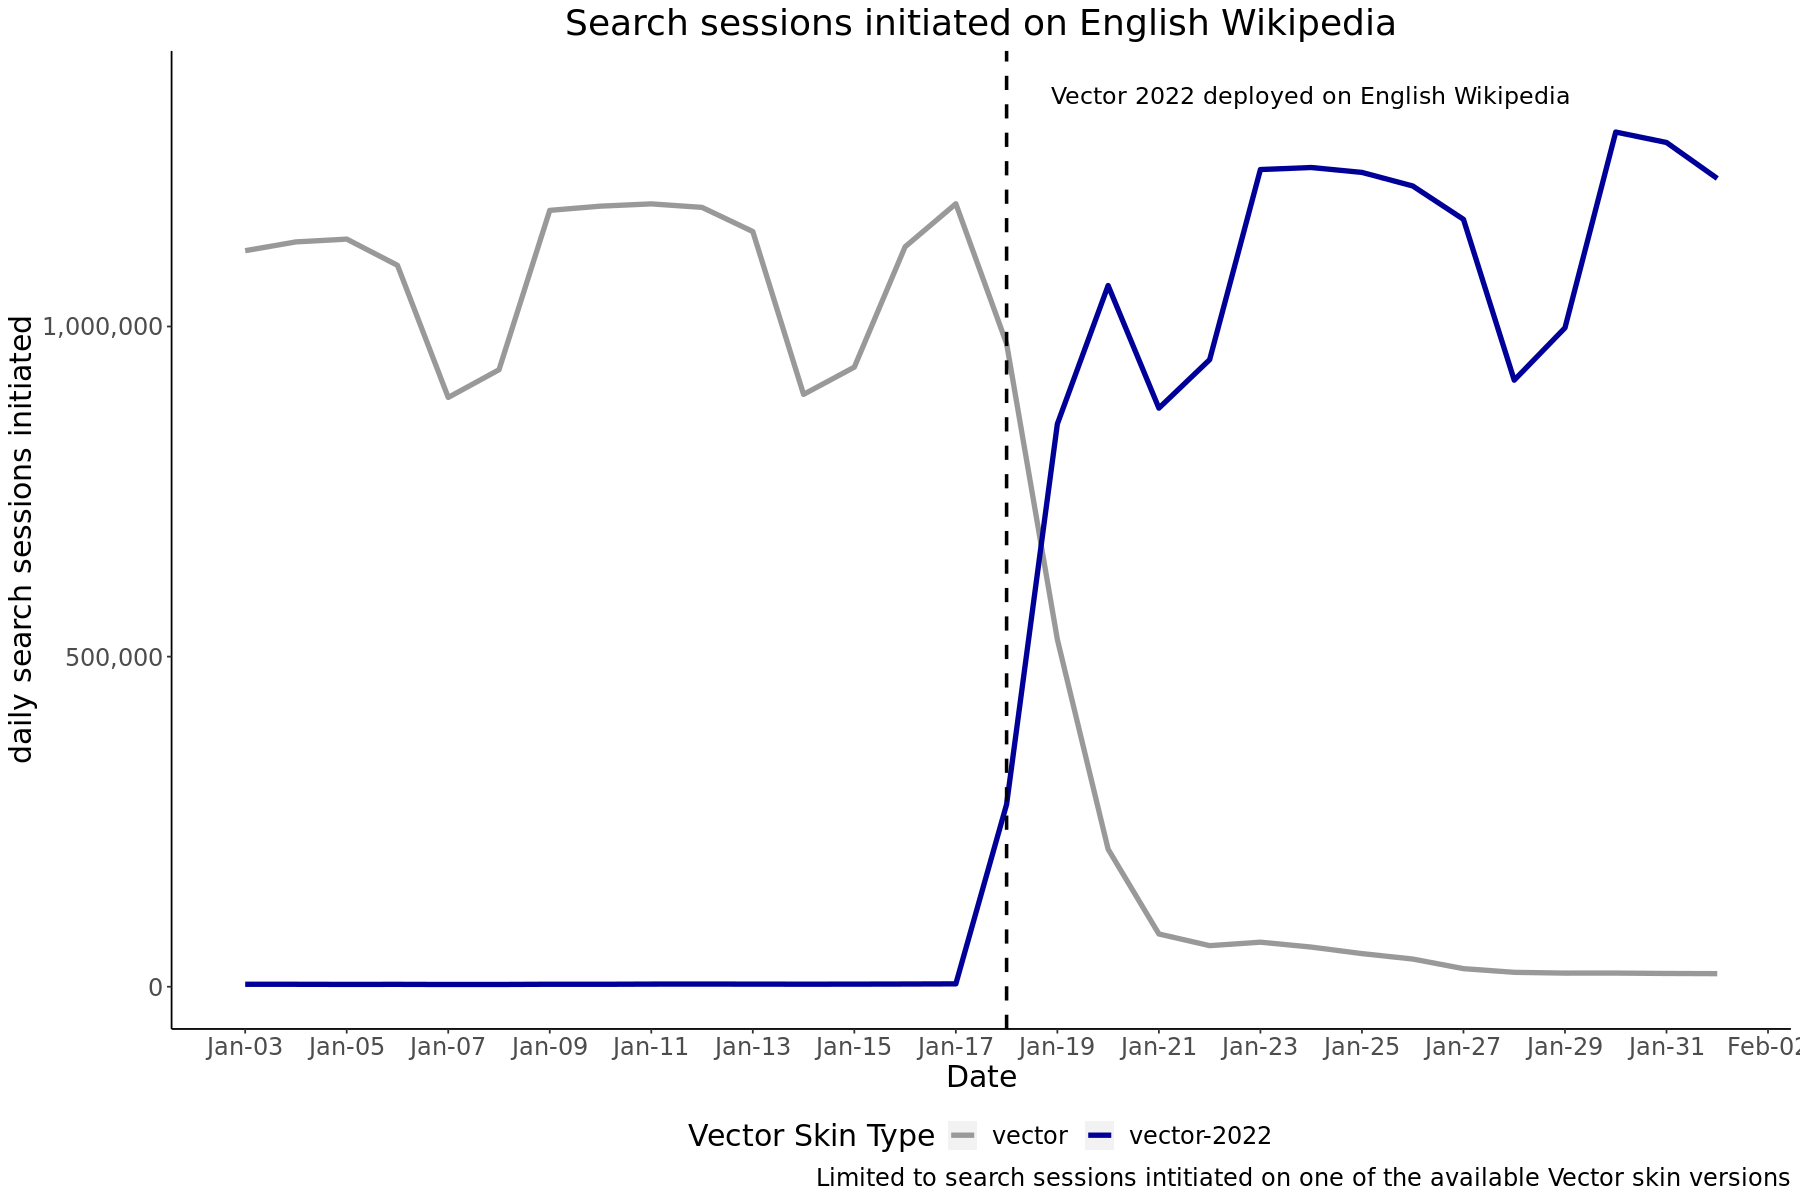

In [112]:
# Chart search sessions initiated over time.

textaes <- data.frame(y = 1350000,
                      x = as.Date('2023-01-24'),
                      lab = "Vector 2022 deployed on English Wikipedia")

p <- enwiki_search_initiated_byskin_daily %>%
    filter(skin %in% c('vector', 'vector-2022'))  %>% #limit to vector searches
    ggplot(aes(x= session_start_date, y = num_sessions, color = skin)) +    
    geom_line(size =1.5) +
    geom_vline(xintercept = as.Date('2023-01-18'), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    scale_y_continuous(labels = scales::comma) +
    scale_x_date("Date", date_breaks = "2 days", date_labels = "%b-%d") +
    scale_color_manual(values= c("#999999", "#000099"), name = "Vector Skin Type")  +
  labs(title = "Search sessions initiated on English Wikipedia",
      y = "daily search sessions initiated",
      x= "Date",
      caption = "Limited to search sessions intitiated on one of the available Vector skin versions") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/enwiki_search_initiated_byskin_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

Trends appear as expected. We see an initial increase on Vector 2022 search session on the date of deployment, 18 Jan 2022, and then a more significant increase on 19 Jan 2022 after all users have had access to the new desktop skin for a full day. 

### Two Weeks Pre and Post Deployment

In [114]:
# sessions initated overall by group
enwiki_search_initiated_byskintype <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    mutate(pre_post = ifelse( session_start_date < '2023-01-18', 'pre', 'post')) %>%
    group_by(pre_post, skin) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

enwiki_search_initiated_byskintype

pre_post,skin,num_sessions
<chr>,<chr>,<int>
post,cologneblue,2297
post,fallback,2
post,modern,4165
post,monobook,47579
post,timeless,8249
post,vector,2200433
post,vector-2022,15817186
pre,cologneblue,2310
pre,modern,4420


The majority of search sessions initiated (99.3%) were on Vector two weeks before deployment. Following deployment of Vector 2022 on 18 Jan 2023, 87.5% of search sessions were initiated on Vector-2022 and 12.2% of search sessions initated were on Vector. Note: The post-deployment numbers may include some search sessions that may have started on 18 Jan 2023 but prior to the deployment of Vector 2022 around 15:30 UTC. 


## By User Experience

We also reviewed search sessions by user experience as indicated by their cumulative edit count on English Wikipedia. This is limited to logged-in users since we do not track the edit count of logged-out users. 

### Daily

In [106]:
# sessions initated overall by edit count group
enwiki_search_initiated_byedit_daily <- enwiki_search_usage  %>%
    filter(is_anonymous == 'logged-in', #remove logged-in users
           session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    group_by(session_start_date, edit_count ) %>%
    summarise(
             num_sessions = n_distinct(search_session)) 


In [108]:
# show immediate changes

enwiki_search_initiated_byedit_daily  %>% 
    filter(session_start_date >= '2023-01-17' &  session_start_date <= '2023-01-19') 

session_start_date,edit_count,num_sessions
<date>,<fct>,<int>
2023-01-17,0 edits,5550
2023-01-17,1-4 edits,3661
2023-01-17,5-99 edits,11291
2023-01-17,100-999 edits,10117
2023-01-17,1000+ edits,16906
2023-01-18,0 edits,6320
2023-01-18,1-4 edits,3905
2023-01-18,5-99 edits,11888
2023-01-18,100-999 edits,10270


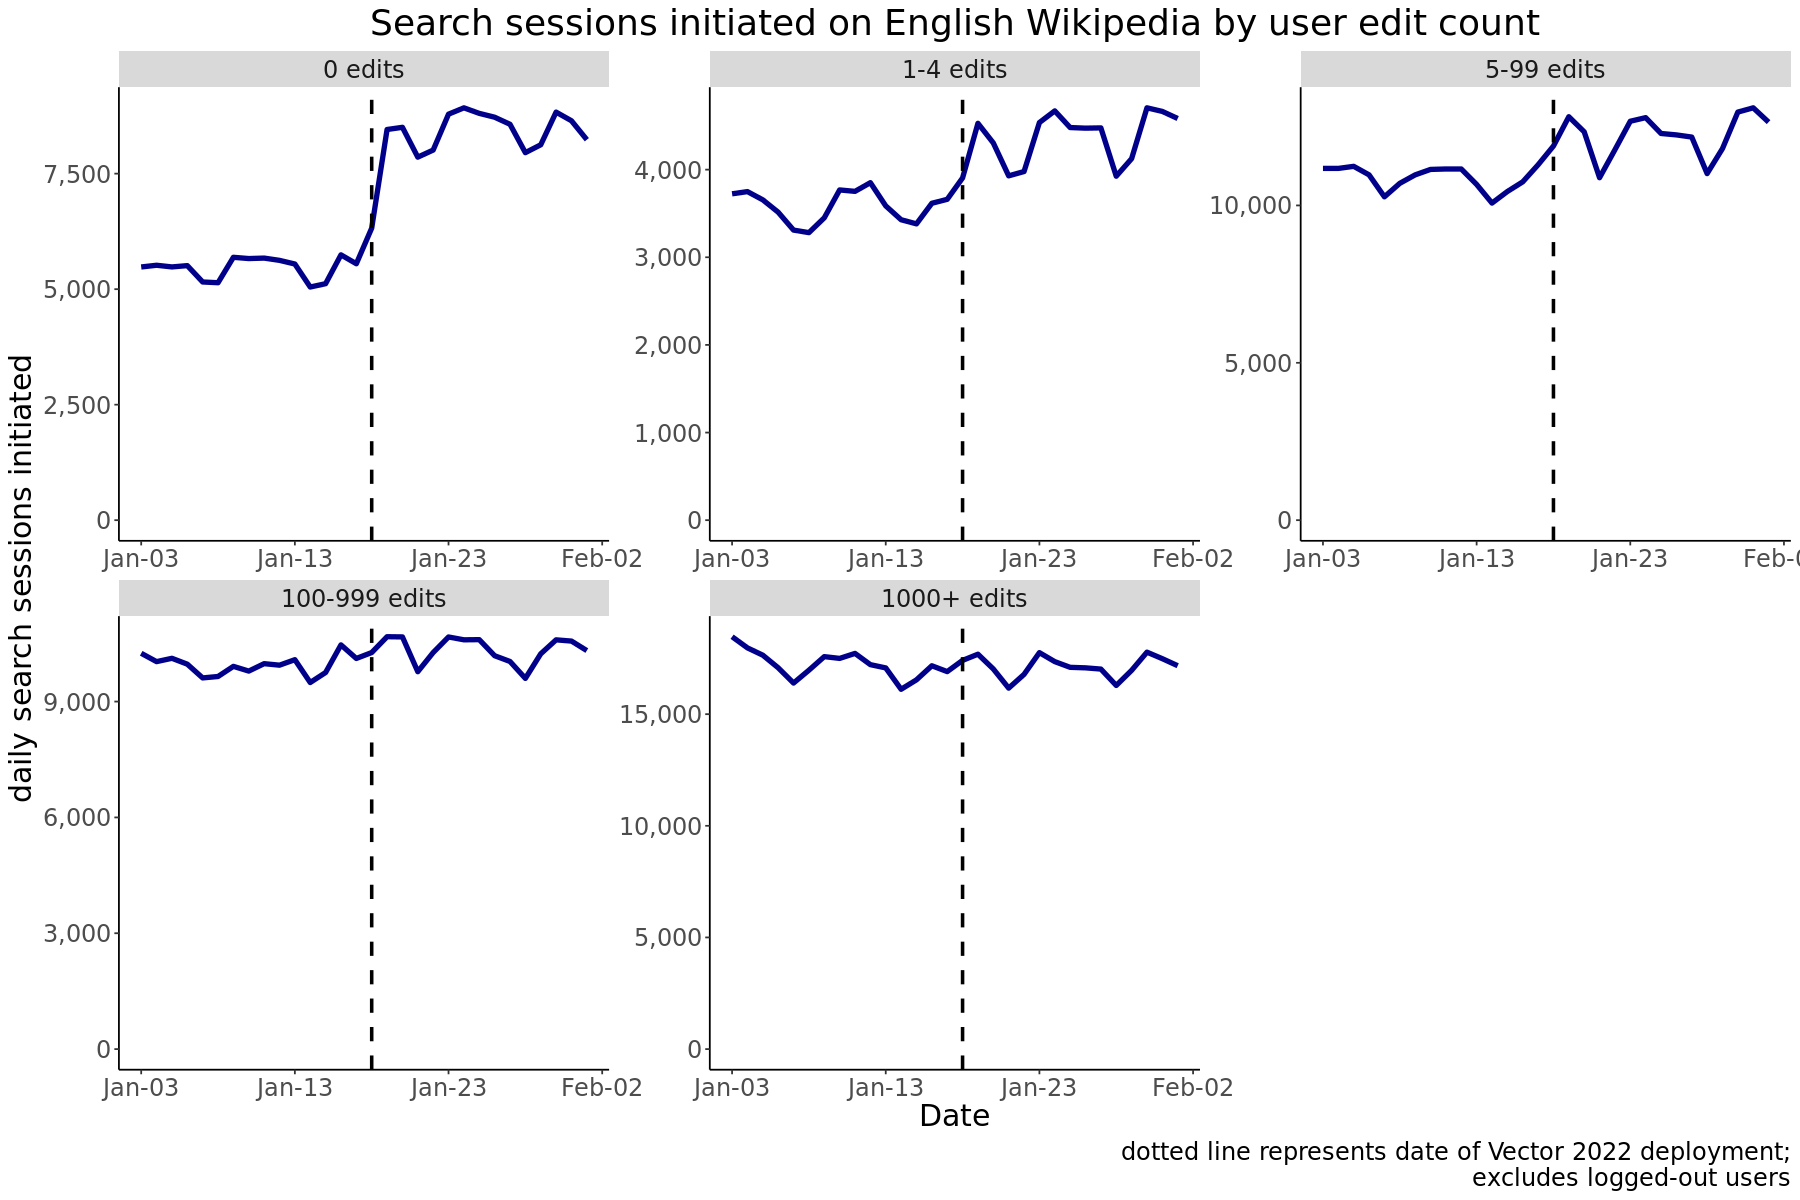

In [156]:
# Chart search sessions initiated over time.
options(repr.plot.width = 15, repr.plot.height = 10)

p <- enwiki_search_initiated_byedit_daily  %>%
    ggplot(aes(x= session_start_date, y = num_sessions)) +    
    geom_line(size =1.5, color = 'darkblue') +
    facet_wrap (~ edit_count, scales = 'free') +
    geom_vline(xintercept = as.Date('2023-01-18'), linetype = 'dashed', size = 1) +
    scale_y_continuous(labels = scales::comma) +
     expand_limits(y=0) +
    scale_x_date("Date", date_breaks = "10 days", date_labels = "%b-%d") +
  labs(title = "Search sessions initiated on English Wikipedia by user edit count",
      y = "daily search sessions initiated",
      x= "Date",
      caption = "dotted line represents date of Vector 2022 deployment;
excludes logged-out users") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/enwiki_search_initiated_byedit_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

Search sessions initiated also increased for all user edit count groups.  There was a more significant and immediate increase for users with no edits or junior editors (with under 100 edits). Note: This excludes logged-out users. Percent increases for each edit count group notes below:

* 0 edits: 54.3%  increase
* 1-4 edits: 23.7% increase
* 5 - 99 edits: 13.5% increase
* 100-999 edits: 5.6% increase
* 1000+ edits: 4.6% increase 
 

### Two Weeks Pre and Post Deployment

In [132]:
# sessions initated overall by edit count
enwiki_search_initiated_byeditcount <- enwiki_search_usage  %>%
    filter(is_anonymous == 'logged-in',
           session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    mutate(pre_post = ifelse( session_start_date < '2023-01-18', 'pre-deployment', 'post-deployment'),
            pre_post = factor(
            pre_post,
            levels = c("pre-deployment", "post-deployment" ))) %>%
    group_by(pre_post, edit_count) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

enwiki_search_initiated_byeditcount

pre_post,edit_count,num_sessions
<fct>,<fct>,<int>
pre-deployment,0 edits,81924
pre-deployment,1-4 edits,53724
pre-deployment,5-99 edits,163190
pre-deployment,100-999 edits,149173
pre-deployment,1000+ edits,258296
post-deployment,0 edits,124727
post-deployment,1-4 edits,65279
post-deployment,5-99 edits,183382
post-deployment,100-999 edits,155088


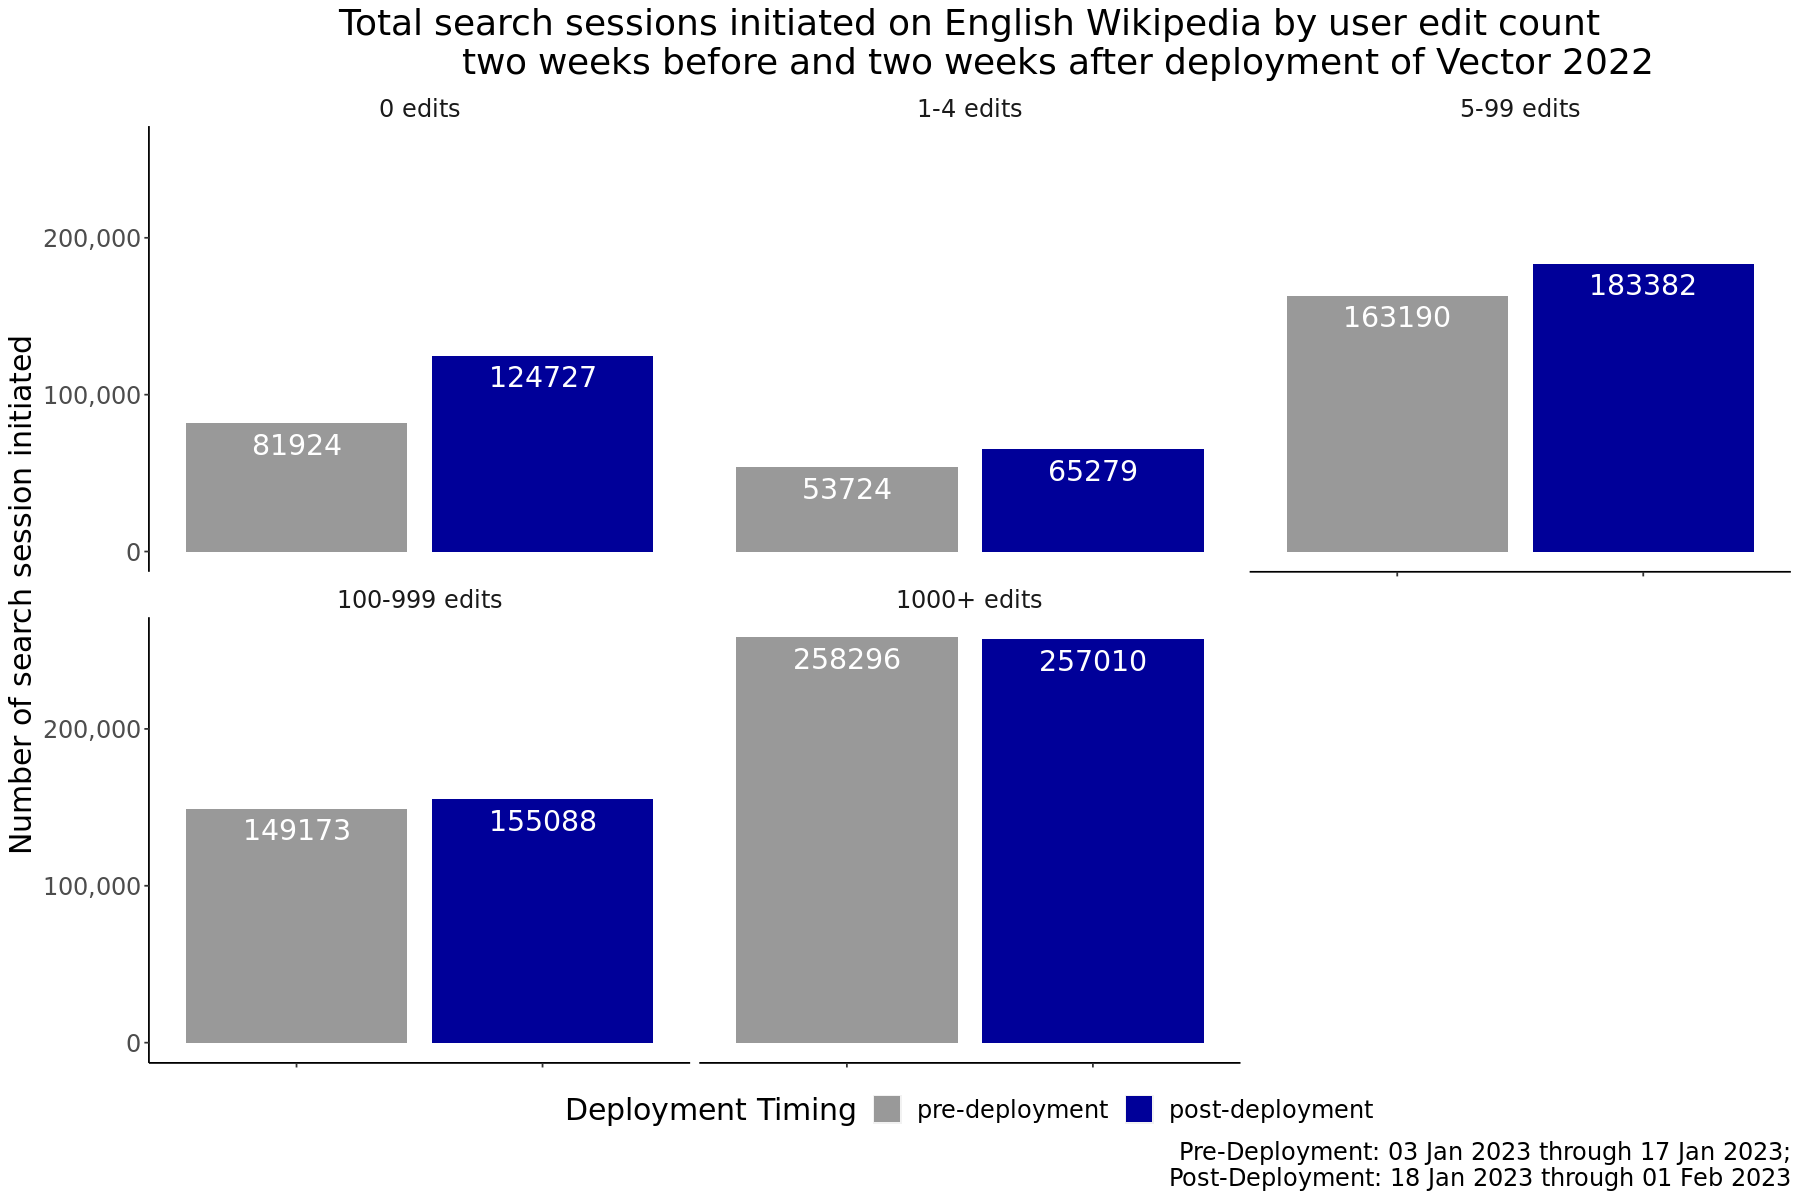

In [151]:
# Plot search sessions initiated by edit count pre and post

p <- enwiki_search_initiated_byeditcount %>%
        ggplot(aes(x = pre_post, y= num_sessions, fill = pre_post)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 6) +
        facet_wrap(~ edit_count)+
        labs (x = "Deployment Timing",
              y = "Number of search session initiated",
             title = "Total search sessions initiated on English Wikipedia by user edit count
                two weeks before and two weeks after deployment of Vector 2022",
             caption = "Pre-Deployment: 03 Jan 2023 through 17 Jan 2023;
                        Post-Deployment: 18 Jan 2023 through 01 Feb 2023") +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment Timing")  +
        scale_y_continuous(labels = scales::comma) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

ggsave("Figures/enwiki_search_initiated_byedit_prepost.png", p, width = 16, height = 8, units = "in", dpi = 300) 

These increases have mostly been sustained two weeks post-deployment of Vector 2022 for all user edit groups. Comparing the total search sessions initiated two weeks pre and post-deployment, we observed increases for all user edit count groups except for very senior editors with over 1000+ edits where there were no significant changes in total search sessions initiated.  See percent changes noted below:

* 0 edits: 52.5%  increase
* 1-4 edits: 21.5% increase
* 5 - 99 edits: 12.4% increase
* 100-999 edits: 4.0%% increase
* 1000+ edits: -0.5% decrease 



## By Logged-in Status

### Daily

In [136]:
# sessions initated overall by logged in status
enwiki_search_initiated_byanon_daily <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    group_by(session_start_date, is_anonymous ) %>%
    summarise(
             num_sessions = n_distinct(search_session)) 

In [137]:
## show immediate changes

enwiki_search_initiated_byanon_daily  %>% 
    filter(session_start_date >= '2023-01-17' &  session_start_date <= '2023-01-19') 

session_start_date,is_anonymous,num_sessions
<date>,<fct>,<int>
2023-01-17,logged-out,1146871
2023-01-17,logged-in,47515
2023-01-18,logged-out,1142485
2023-01-18,logged-in,49782
2023-01-19,logged-out,1185997
2023-01-19,logged-in,54156


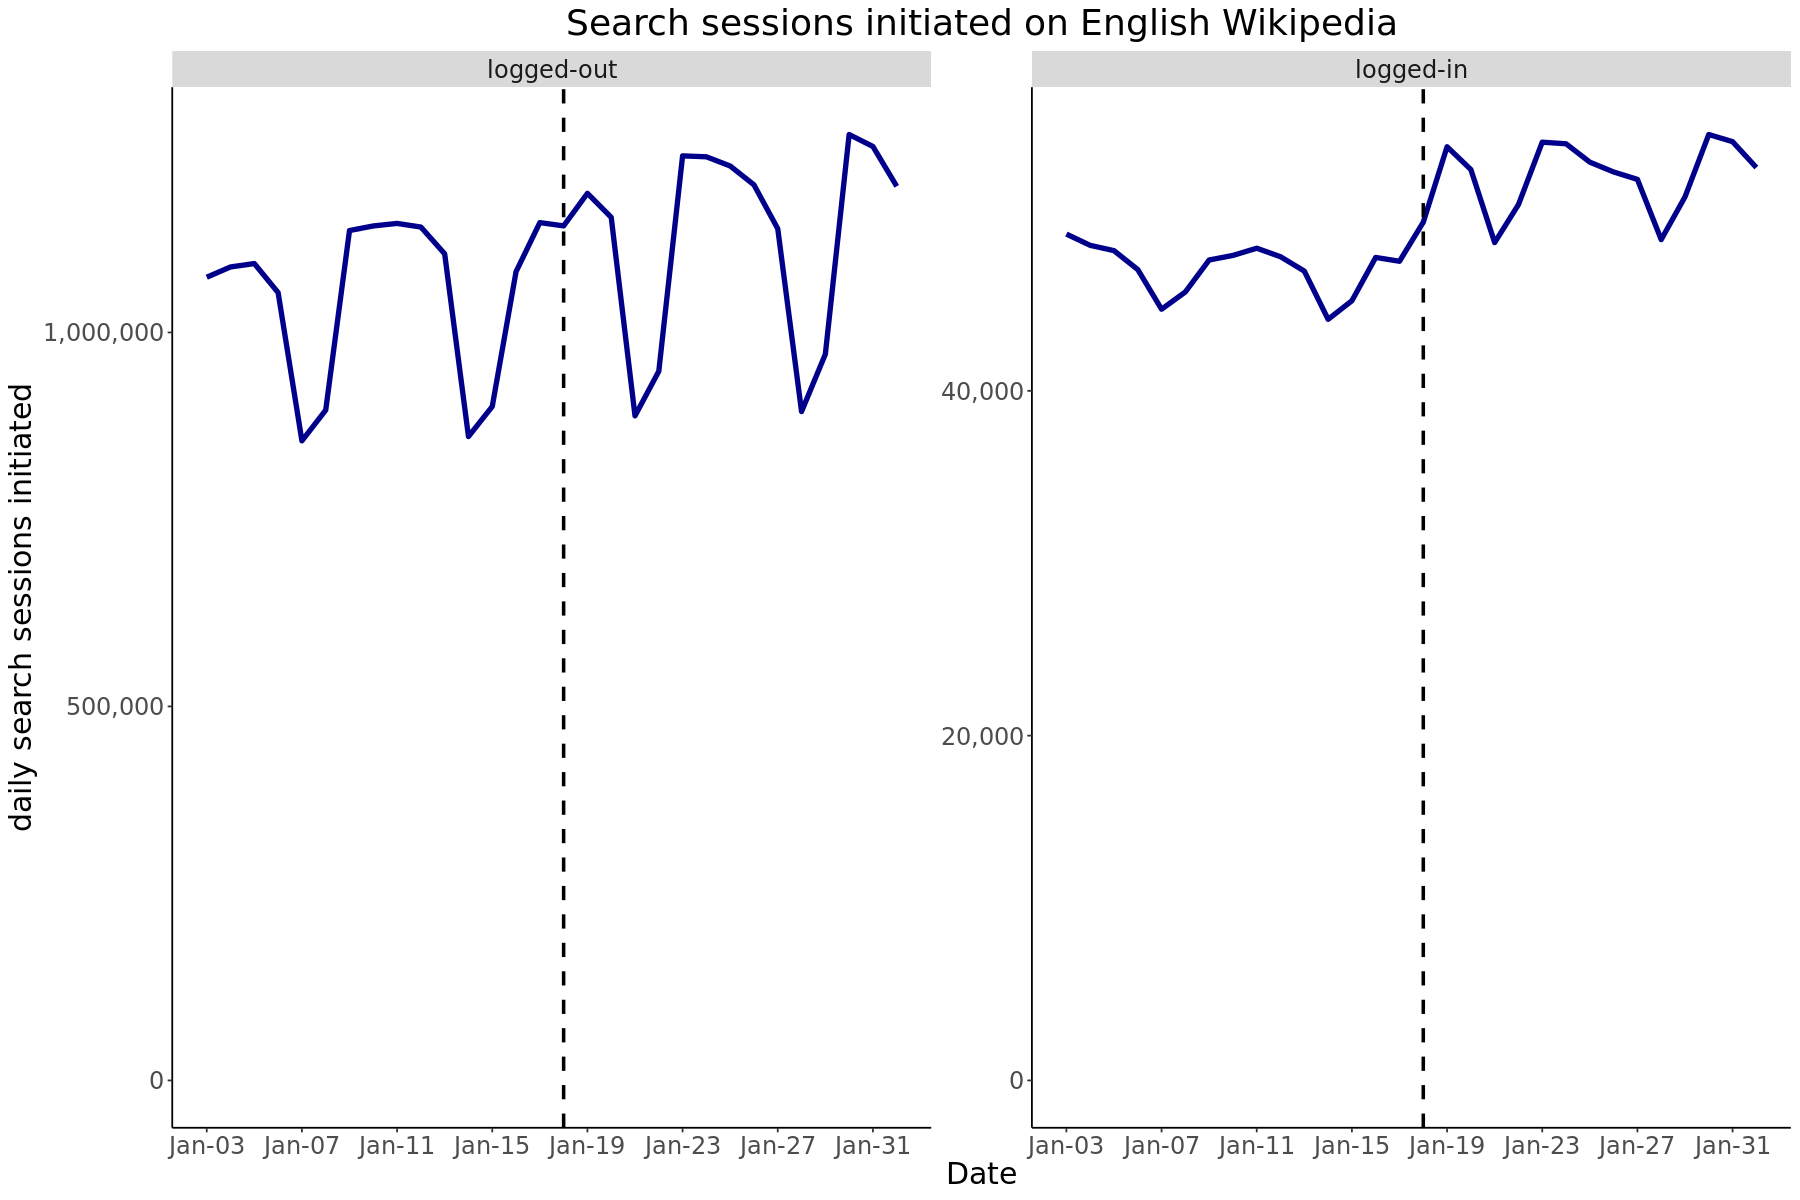

In [153]:
# Chart search sessions initiated over time.


p <- enwiki_search_initiated_byanon_daily%>%
    ggplot(aes(x= session_start_date, y = num_sessions)) +    
    geom_line(size =1.5, color = 'darkblue') +
    facet_wrap(~is_anonymous, scales = "free_y") +
    geom_vline(xintercept = as.Date('2023-01-18'), linetype = 'dashed', size = 1) +
    scale_y_continuous(labels = scales::comma) +
    expand_limits(y=0) +
    scale_x_date("Date", date_breaks = "4 days", date_labels = "%b-%d") +
    #scale_color_manual() +
  labs(title = "Search sessions initiated on English Wikipedia",
      y = "daily search sessions initiated",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/enwiki_search_initiated_byanon_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

Search sessions initiated increased for both logged in and logged out users post deployment of Vector 2022. There was a more signficant and immediate increase (14% increase) for logged-in users compared to logged-out users (3.4% increase).

See percent increases from 17-Jan-2023 to 19-Jan 2023 noted below:

* Logged-in users: 14.0% increase
* Logged-out users: 3.4% increase

### Two Weeks Pre and Post Deployment

In [139]:
# sessions initated overall by anon status
enwiki_search_initiated_byanon <- enwiki_search_usage  %>%
    filter(session_start_date >= '2023-01-03' &  session_start_date <= '2023-02-01') %>% # two weeks before and after
    mutate(pre_post = ifelse( session_start_date < '2023-01-18', 'pre-deployment', 'post-deployment'),
           pre_post = factor(
            pre_post,
            levels = c("pre-deployment", "post-deployment" ))) %>%
    group_by(pre_post, is_anonymous) %>%
    summarise(
             num_sessions = n_distinct(search_session), .groups = 'drop') 

enwiki_search_initiated_byanon

pre_post,is_anonymous,num_sessions
<fct>,<fct>,<int>
pre-deployment,logged-out,15718242
pre-deployment,logged-in,706176
post-deployment,logged-out,16921084
post-deployment,logged-in,785377


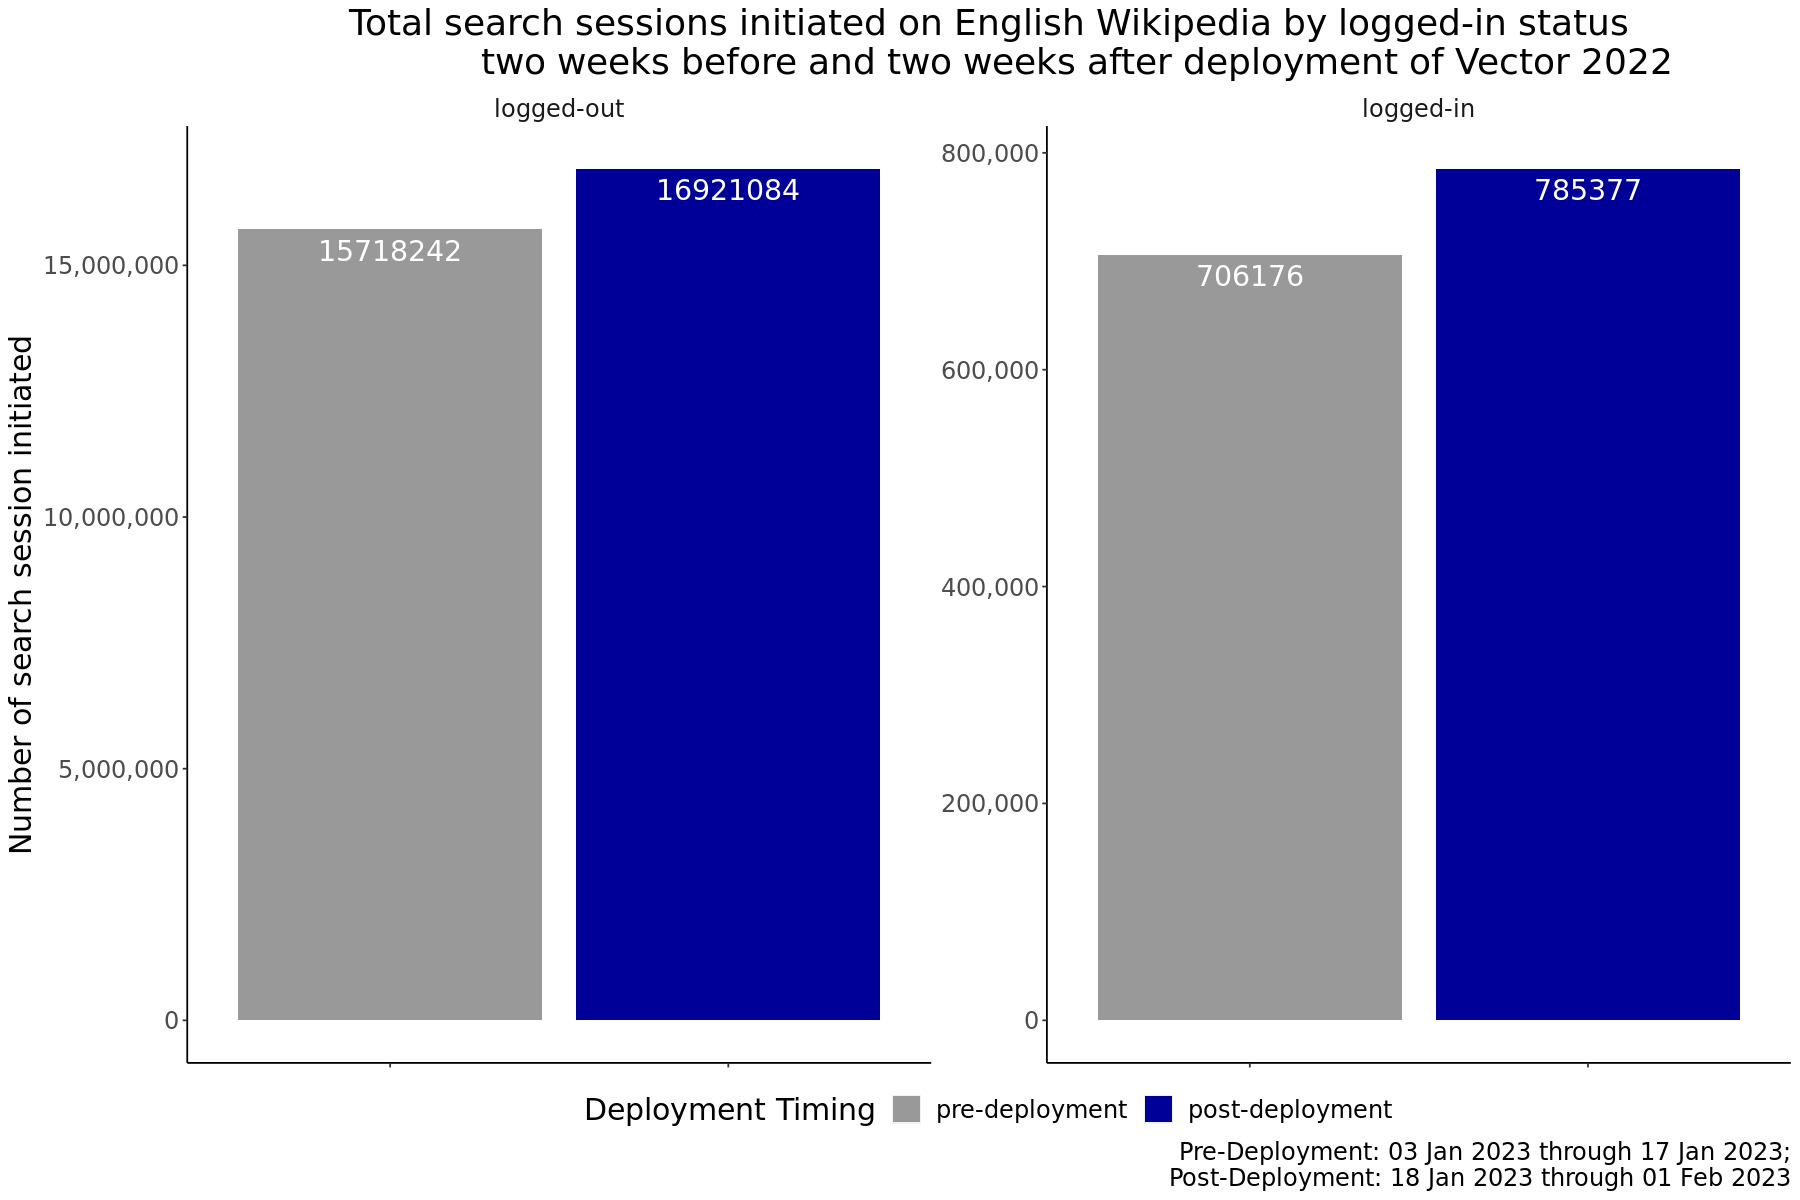

In [155]:
# Plot search sessions initiated by logged in status pre and post

p <- enwiki_search_initiated_byanon %>%
        ggplot(aes(x = pre_post, y= num_sessions, fill = pre_post)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(num_sessions)), color = "white", vjust=1.5, size = 6) +
        facet_wrap(~ is_anonymous, scales = "free_y")+
        labs (x = "Deployment Timing",
              y = "Number of search session initiated",
             title = "Total search sessions initiated on English Wikipedia by logged-in status
                two weeks before and two weeks after deployment of Vector 2022",
             caption = "Pre-Deployment: 03 Jan 2023 through 17 Jan 2023;
                        Post-Deployment: 18 Jan 2023 through 01 Feb 2023") +
        scale_fill_manual(values= c("#999999", "#000099"), name = "Deployment Timing")  +
        scale_y_continuous(labels = scales::comma) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

ggsave("Figures/enwiki_search_initiated_byanon_prepost.png", p, width = 16, height = 8, units = "in", dpi = 300) 

Search sessions initiated also increased for both logged in and logged out users two weeks post deployment compared to two week pre deployment. See percent changes noted below:

* Logged-in users: 11.2% increase
* Logged-out users: 7.7%% increase
